# Lecture 23 – Data 100, Fall 2024

Data 100, Fall 2024

[Acknowledgments Page](https://ds100.org/fa24/acks/)

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates["plotly"].layout.colorway = px.colors.qualitative.Vivid
px.defaults.width = 800

from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.linear_model as lm

We'll continue with the `games` dataset from last lecture.

In [2]:
basketball = pd.read_csv("data/nba.csv")
first_team = basketball.groupby("GAME_ID").first()
second_team = basketball.groupby("GAME_ID").last()
games = first_team.merge(second_team, left_index = True, right_index = True, suffixes = ["", "_OPP"])
games['GOAL_DIFF'] = games["FG_PCT"] - games["FG_PCT_OPP"]
games['WON'] = (games['WL'] == "W").astype(int)
games = games[['TEAM_NAME', 'TEAM_NAME_OPP', 'MATCHUP', 'WON', 'WL', 'AST', 'GOAL_DIFF']]
games

,TEAM_NAME,TEAM_NAME_OPP,MATCHUP,WON,WL,AST,GOAL_DIFF
GAME_ID,,,,,,,
21700001,Boston Celtics,Cleveland Cavaliers,BOS @ CLE,0,L,24,-0.049
21700002,Golden State Warriors,Houston Rockets,GSW vs. HOU,0,L,34,0.053
21700003,Charlotte Hornets,Detroit Pistons,CHA @ DET,0,L,16,-0.030
21700004,Indiana Pacers,Brooklyn Nets,IND vs. BKN,1,W,29,0.041
21700005,Orlando Magic,Miami Heat,ORL vs. MIA,1,W,22,0.042
...,...,...,...,...,...,...,...
21701226,New Orleans Pelicans,San Antonio Spurs,NOP vs. SAS,1,W,30,0.189
21701227,Oklahoma City Thunder,Memphis Grizzlies,OKC vs. MEM,1,W,32,0.069
21701228,LA Clippers,Los Angeles Lakers,LAC vs. LAL,0,L,27,0.017


As before, we will use the `"GOAL_DIFF"` feature to classify whether a team won (1) or lost (0) their game.

In [3]:
np.random.seed(42)
games["JitterWON"] = games["WON"] + np.random.uniform(-0.1, 0.1, len(games))
px.scatter(games, 
           x="GOAL_DIFF", y="JitterWON", color="WL", 
           hover_data=['TEAM_NAME', 'TEAM_NAME_OPP'])

## Decision Boundaries

The `LogisticRegression` class of `sklearn.linear_model` behaves very similarly to the `LinearRegression` class. As before, we:

1. Initialize a model object, and
2. Fit it to our data.

Now, rather than predicting a numeric output, we predict the *probability* of a datapoint belonging to Class 1. We do this using the `.predict_proba` method.

In [4]:
X = games[["GOAL_DIFF"]]
Y = games["WON"]

model = lm.LogisticRegression()
model.fit(X, Y)
print("Slope:", model.coef_[0][0])
print("Intercept:", model.intercept_[0])


Slope: 11.822010640307564
Intercept: -0.022954660860397533


In [5]:
# Preview the first 10 rows
model.predict_proba(X)[:10]

array([[0.64616706, 0.35383294],
       [0.35351778, 0.64648222],
       [0.59329774, 0.40670226],
       [0.38657128, 0.61342872],
       [0.38377167, 0.61622833],
       [0.59044202, 0.40955798],
       [0.7031446 , 0.2968554 ],
       [0.63253864, 0.36746136],
       [0.31157548, 0.68842452],
       [0.61590222, 0.38409778]])

By default, `.predict_proba` returns a 2D array. One column contains the predicted probability that the datapoint belongs to Class 0, and the other contains the predicted probability that it belongs to Class 1 (notice that all rows sum to a total probability of 1). To check which is which, we can use the `.classes_` attribute.

In [6]:
model.classes_

array([0, 1])

This tells us that the first column contains the probabilities of belonging to Class 0 (losing the game), and the second column contains the probabilities of belonging to Class 1 (winning). Let's grab just the probabilities of Class 1.

We then apply a decision rule: Predict Class 1 if the predicted probability of belonging to Class 1 is 0.5 or higher. Otherwise, predict Class 0.

In [7]:
# Obtain P(Y=1|x) from the output.
p = model.predict_proba(X)[:, 1]

# Apply decision rule: predict Class 1 if P(Y=1|x) >= 0.5.
(p >= 0.5).astype(int)

array([0, 1, 0, ..., 1, 0, 0])

The `.predict` method of `LogisticRegression` will automatically apply a 0.5 threshold to classify data.

In [8]:
# .predict will automatically apply a 0.5 threshold for a logistic regression model.
classes = model.predict(X)

classes

array([0, 1, 0, ..., 1, 0, 0])

The point where the sigmoid function outputs 0.5 is the decision boundary. This is the point where the model is indifferent between predicting Class 0 and Class 1.  This is also the point where $\theta_0 + \theta_1 x = 0$. For this one dimensional case we can solve for the $x$ value of the decision boundary:

$$
x = - \frac{\theta_0}{\theta_1} = - \frac{\text{intercept}}{\text{slope}}
$$

Let's visualize our predictions.

In [9]:
games["Predicted Class"] = pd.Categorical(classes)

test_points = pd.DataFrame({"GOAL_DIFF": np.linspace(-0.3, 0.3, 100)})
test_points["Predicted Prob"] = model.predict_proba(test_points)[:, 1]

fig = px.scatter(games, 
           x="GOAL_DIFF", y="JitterWON", color="Predicted Class", 
           hover_data=['TEAM_NAME', 'TEAM_NAME_OPP'])
# Add the logistic regression model predictions
fig.add_trace(go.Scatter(x=test_points["GOAL_DIFF"], y=test_points["Predicted Prob"], 
                         mode="lines", name="Logistic Regression Model", 
                         line_color="black", line_width=5, line_dash="dash"))
fig.add_vline(x = -model.intercept_[0]/model.coef_[0][0], line_dash="dash", 
              line_color="black",
              annotation_text="Decision Boundary", 
              annotation_position="right")


Any time the predicted probability $p$ is less than 0.5, the model predicts Class 0. Otherwise, it predicts Class 1.

A decision boundary describes the line that splits the data into classes based on the *features*.

For a model with one feature, the decision boundary is a *point* that separates the two classes. We visualize this using a 1D plot to plot all data points in terms of *just* the feature – we cannot define a decision boundary in terms of the predictions, so we remove that axis from our plot.

Notice that all data points to the right of our decision boundary are classified as Class 1, while all data points to the left are classified as Class 0.

In [15]:
fig = px.scatter(games, x="GOAL_DIFF", y=np.zeros(len(games)), 
                 symbol="WL", symbol_sequence=[ "circle-open", "cross"], 
                 color="Predicted Class", height=300, opacity=0.7)
# fig.update_traces(marker_symbol='line-ns-open')
fig.update_traces(marker_size=8)
fig.update_layout(
    yaxis=dict(showticklabels=False, showgrid=False, zeroline=False, title=""),
)

decision_boundary =  -model.intercept_[0]/model.coef_[0][0]
fig.add_vline(x = decision_boundary, line_dash="dash", 
              line_color="black",
              annotation_text="Decision Boundary", 
              annotation_position="top right")

## Two Features

We can repeat this process with a model with two features: `"AST"` and `"GOAL_DIFF"`. Now, we express a decision boundary in terms of both of these two features.

How do we find the decision boundary in this case? We calculate the equation for the line that gives us all the points for which the model output is equal to the threshold:

$$T = \frac{1}{1+e^{-\theta_0 -\theta_1\times\text{GOAL\_DIFF}-\theta_2\times\text{AST}}}$$ 

$$\Longrightarrow$$

$$\theta_0 + \theta_1\times\text{GOAL\_DIFF} + \theta_2\times\text{AST} = - \log(\frac{1}{T}-1)$$


In [16]:
X_two_feature = games[["GOAL_DIFF", "AST"]]
Y = games["WON"]

two_feature_model = lm.LogisticRegression()
two_feature_model.fit(X_two_feature, Y)

# This function plots the decision boundary such that AST is a function of GOAL_DIFF.
theta0 = two_feature_model.intercept_
theta1, theta2 = two_feature_model.coef_[0]
print(theta0, theta1, theta2)


[-2.11190144] 10.785697735287494 0.09027834044673858


Make predictions using the new model:

In [17]:
games["Predicted Class"] = pd.Categorical(two_feature_model.predict(X_two_feature))
games.head()

,TEAM_NAME,TEAM_NAME_OPP,MATCHUP,WON,WL,AST,GOAL_DIFF,JitterWON,Predicted Class
GAME_ID,,,,,,,,,
21700001,Boston Celtics,Cleveland Cavaliers,BOS @ CLE,0,L,24,-0.049,-0.025092,0
21700002,Golden State Warriors,Houston Rockets,GSW vs. HOU,0,L,34,0.053,0.090143,1
21700003,Charlotte Hornets,Detroit Pistons,CHA @ DET,0,L,16,-0.030,0.046399,0
21700004,Indiana Pacers,Brooklyn Nets,IND vs. BKN,1,W,29,0.041,1.019732,1
21700005,Orlando Magic,Miami Heat,ORL vs. MIA,1,W,22,0.042,0.931204,1


Plotting the new model:

In [18]:
fig = px.scatter(games, x="GOAL_DIFF", y="AST", symbol="WL", 
           color="Predicted Class", 
           symbol_sequence=[ "circle-open", "cross"],
           opacity=0.7)
fig.update_traces(marker=dict(size=8))
fig.update_layout(xaxis_range=[-0.3, 0.3], yaxis_range=[5, 50])

# Construct the decision boundary
decision_boundary = pd.DataFrame({"GOAL_DIFF": np.linspace(-0.3, 0.3, 100)})
decision_boundary["AST"] = (-theta0 - theta1*decision_boundary["GOAL_DIFF"])/theta2

# Add the decision boundary to the plot
fig.add_scatter(x=decision_boundary["GOAL_DIFF"], y=decision_boundary["AST"],
                mode="lines", line_color="black", line_dash="dash", 
                name="Decision Boundary")

## Linear Separability

A **linearly separable** dataset is one that can be perfectly separated into two classes by a hyperplane among the input features. A hyperplane is a decision boundary extended to arbitrarily many dimensions (for example, a model with three features would have a 3D surface as its decision boundary).

In [27]:
import seaborn as sns
iris = sns.load_dataset("iris")


This dataset is linearly separable:

In [35]:
fig = px.scatter(iris[iris["species"] != "virginica"], 
                 x = "petal_length",
                 y = "petal_width", 
                 color="species", 
                 symbol="species", symbol_sequence=[ "circle", "cross"])
fig.update_traces(marker=dict(size=12))
fig

And this dataset is not.

In [36]:
fig = px.scatter(iris[iris["species"] != "setosa"], 
                 x = "petal_length",
                 y = "petal_width", 
                 color="species", 
                 symbol="species", symbol_sequence=[ "circle", "cross"])
fig.update_traces(marker=dict(size=12))
fig

When our data is linearly separable, we run the risk of **diverging weights** as the model attempts to reduce cross-entropy loss to 0.

To see why, consider the following artificially generated "toy" dataset.

In [40]:
toy_df = pd.DataFrame({"x": [-1, 1], "y": [0, 1], "label": pd.Categorical([0, 1])})
fig = px.scatter(toy_df, x="x", y="y", 
                 color="label", symbol="label", 
                 symbol_sequence=[ "circle", "cross"])
fig.update_traces(marker=dict(size=12))

Let's look at the mean cross-entropy loss surface for this toy dataset, and a single feature model $\hat{y} = \sigma(\theta x)$.

For this situation, our logistic regression model takes the form:

$$ \Large \hat{P}_{\theta}(Y = 1 | x) = \sigma(\theta_1 x) = \frac{1}{1 + e^{-\theta_1 x}} $$

With mean cross-entropy loss:

\begin{align}
\hat{\theta} &= \underset{\theta}{\operatorname{argmin}}  - \frac{1}{n} \sum_{i=1}^n \left( y_i \log (\sigma(\theta_1 x_i) + (1 - y_i) \log (1 - \sigma(\theta_1 x_i)) \right) \\
&= \underset{\theta}{\operatorname{argmin}} -\frac{1}{2} \left[ \log (\sigma( -  \theta_1 )) + \log(1 - \sigma(\theta_1))\right]
\end{align}

In [59]:
def toy_model(theta1, x):
    return 1/(1 + np.exp(-theta1 * x))

def mean_cross_entropy_loss_toy(theta1):
    # Here we use 1 - sigma(z) = sigma(-z) to improve numerical stability.
    return - np.sum(toy_df['y'] * np.log(toy_model(theta1, toy_df['x'])) + \
                    (1-toy_df['y']) * np.log(toy_model(theta1, -toy_df['x'])))

In [61]:
thetas = np.linspace(-30, 30, 100)
fig = px.line(x=thetas, y = [mean_cross_entropy_loss_toy(theta) for theta in thetas])
fig.update_layout(xaxis_title="Theta", yaxis_title="Mean CE Loss",
                  title="Mean Cross Entropy Loss for Toy Example")

Let's switch the y-axis to log scale to better visualize the loss surface for larger $\theta$.

In [ ]:
fig = px.line(x=thetas, y = [mean_cross_entropy_loss_toy(theta) for theta in thetas],
              log_y=True)
fig.update_layout(xaxis_title="Theta", yaxis_title="Log Scale Mean CE Loss",
                  title="Log Scale Mean Cross Entropy Loss for Toy Example")

We can keep decreasing the loss if we increase the value of $\theta$.

If left unchecked, the logistic regression model will attempt to use *infinite* values as the "optimal" model parameters. We describe this phenomenon as the model weights "**diverging**". 

We can use **regularization** to restrict how large the model parameters can be.

In [63]:
def regularized_loss_toy(theta1, reg):
    return mean_cross_entropy_loss_toy(theta1) + reg * theta1**2

In [68]:
reg = 0.01 # Small amount of regularization
fig = px.line(x=thetas, y = [regularized_loss_toy(theta, reg) for theta in thetas])
fig.update_layout(xaxis_title="Theta", yaxis_title="Mean CE Loss",
                  title=f"Mean Cross Entropy Loss for Toy Example (Regularization = {reg})")

Much better!

By default, `sklearn`'s `LogisticRegression` applies regularization for us. Phew.

## Performance Metrics

Let's return to our `games` data. We'll compute the **accuracy** of our `model` on this data.



In [20]:
def accuracy(X, Y):
    return np.mean(model.predict(X) == Y)

accuracy(X, Y)

np.float64(0.7943089430894309)

As per usual, `scikit-learn` can do this for us. The `.score` method of a `LogisticRegression` classifier gives us the accuracy of it.

In [21]:
model.score(X, Y)

0.7943089430894309

### Confusion matrix

Our good old friend `scikit-learn` has an in-built confusion matrix method (of course it does).

In [22]:
from sklearn.metrics import confusion_matrix

# Be careful – confusion_matrix takes in y_true as the first parameter and y_pred as the second.
# Don't mix these up!
cm = confusion_matrix(Y, model.predict(X))
cm

array([[511, 114],
       [139, 466]])

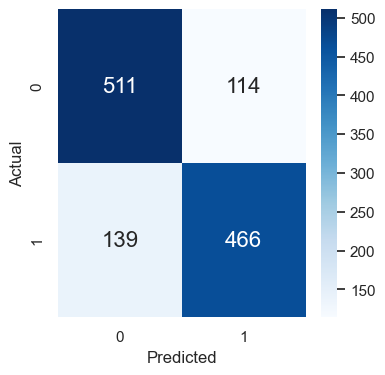

In [23]:
cm = confusion_matrix(Y, model.predict(X))
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');

### Precision and Recall

We can also compute the number of TP, TN, FP, and TN for our classifier, and hence its precision and recall.

In [24]:
Y_hat = model.predict(X)
tp = np.sum((Y_hat == 1) & (Y == 1))
tn = np.sum((Y_hat == 0) & (Y == 0))

fp = np.sum((Y_hat == 1) & (Y == 0))
fn = np.sum((Y_hat == 0) & (Y == 1))

tp, tn, fp, fn

(np.int64(466), np.int64(511), np.int64(114), np.int64(139))

These numbers match what we see in the confusion matrix above.

In [25]:
precision = tp / (tp + fp)
precision

np.float64(0.803448275862069)

In [26]:
recall = tp / (tp + fn)
recall

np.float64(0.7702479338842976)

### True and False Positive Rates

The TP, TN, FP, and TN we just calculated also allow us to compute the true and false positive rates. Recall (haha) that the true positive rate is the same as recall.

In [27]:
fpr = fp/(fp + tn)
fpr

np.float64(0.1824)

In [28]:
tpr = tp/(tp + fn)
tpr

np.float64(0.7702479338842976)

It's important to remember that these values are all for the threshold of $T = 0.5$, which is `scikit-learn`'s default.

## Adjusting the Classification Threshold

Let's remind ourselves of our original `games` data.

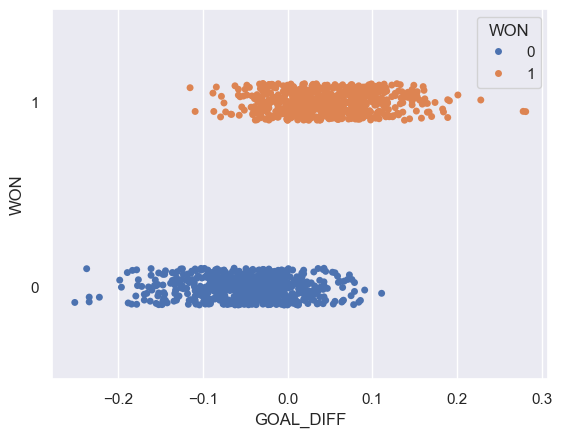

In [29]:
sns.stripplot(data=games, x="GOAL_DIFF", y="WON", orient="h", order=[1, 0], hue="WON");

Before, we used a threshold of 0.5 in our decision rule: If the predicted probability was greater than 0.5 we predicted Class 1, otherwise, we predicted Class 0.

What happens if we change the threshold? Below, we apply a threshold of $T=0.25$.

In [30]:
model = lm.LogisticRegression()
model.fit(X, Y)

p = model.predict_proba(X)[:, 1]

# Predict Class 1 if the predicted probability >= 0.25.
y_hat = (p >= 0.25).astype(int)

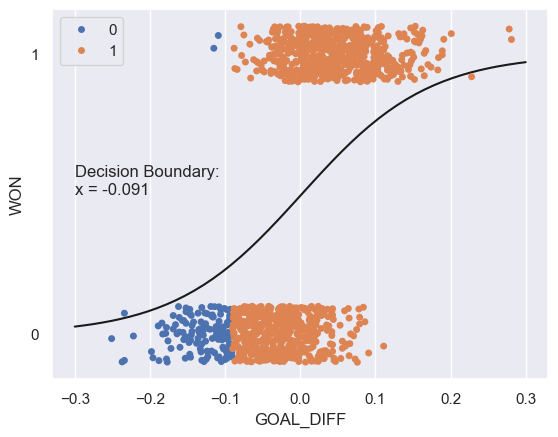

In [31]:
theta0 = model.intercept_
theta1 = model.coef_[0]
decision_boundary_T25 = (1/theta1)*(-np.log(1/0.25 - 1) - theta0)

x = np.linspace(-0.3, 0.3)
sns.stripplot(x=games["GOAL_DIFF"], y=games["WON"], hue=y_hat, orient="h")
plt.plot(x, sigmoid(model.intercept_ + model.coef_[0]*x), "k", label="P(Y=1|x)")
plt.gca().invert_yaxis()

plt.annotate(f"Decision Boundary:\nx = {np.round(decision_boundary_T25[0], 3)}", (-0.3, 0.5));

When we lower the threshold, we require a lower predicted probability before we predict Class 1. We can think of this as us telling our model that it needs to be less "confident" about a data point being Class 1 before making a positive prediction. The total number of data points predicted to be Class 1 increases.

The converse happens if we raise the threshold. Consider setting $T=0.75$. Now, we require a higher predicted probability before we predict Class 1. The total number of data points predicted to be Class 1 decreases.

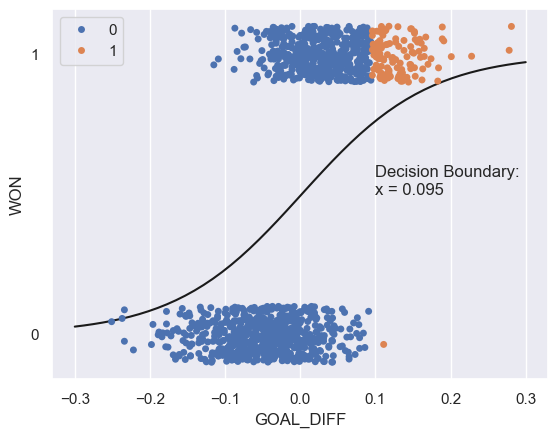

In [32]:
# Predict Class 1 if the predicted probability >= 0.75.
y_hat = (p > 0.75).astype(int)

decision_boundary_T75 = (1/theta1)*(-np.log(1/0.75 - 1) - theta0)

x = np.linspace(-0.3, 0.3)
sns.stripplot(x=games["GOAL_DIFF"], y=games["WON"], hue=y_hat, orient="h")
plt.plot(x, sigmoid(model.intercept_ + model.coef_[0]*x), "k", label="P(Y=1|x)")
plt.gca().invert_yaxis()

plt.annotate(f"Decision Boundary:\nx = {np.round(decision_boundary_T75[0], 3)}", (0.1, 0.5));


## Thresholds and Performance Metrics

How does changing the threshold impact our performance metrics?

Let's run an experiment: we'll test out several different possible thresholds. For each threshold $T$, we'll make a decision rule where we classify any point with a predicted probability equal to or greater than $T$ as being in Class 1. Otherwise, we'll predict Class 0. We'll then compute the overall accuracy of the classifier when using that threshold.

In [33]:
# Define performance metrics dependent on the threshold value.

def predict_threshold(model, X, T): 
    prob_one = model.predict_proba(X)[:, 1]
    return (prob_one >= T).astype(int)

def accuracy_threshold(X, Y, T):
    return np.mean(predict_threshold(model, X, T) == Y)

def precision_threshold(X, Y, T):
    Y_hat = predict_threshold(model, X, T)
    return np.sum((Y_hat == 1) & (Y == 1)) / np.sum(Y_hat == 1)
    
def recall_threshold(X, Y, T):
    Y_hat = predict_threshold(model, X, T)
    return np.sum((Y_hat == 1) & (Y == 1)) / np.sum(Y == 1)

def tpr_threshold(X, Y, T): # Same as recall
    Y_hat = predict_threshold(model, X, T)
    return np.sum((Y_hat == 1) & (Y == 1)) / np.sum(Y == 1)

def fpr_threshold(X, Y, T):
    Y_hat = predict_threshold(model, X, T)
    return np.sum((Y_hat == 1) & (Y == 0)) / np.sum(Y == 0)

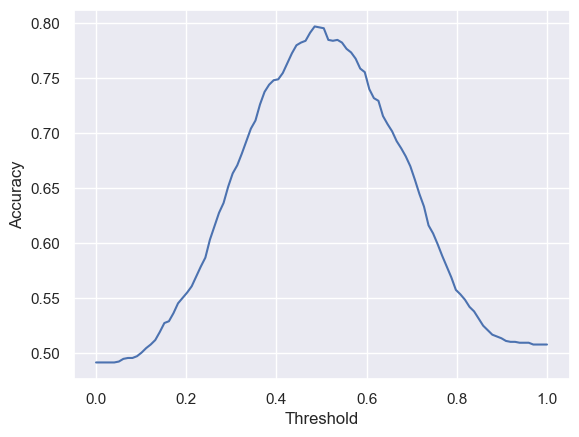

In [34]:
# Compute accuracies for different thresholds.
thresholds = np.linspace(0, 1, 100)
accs = [accuracy_threshold(X, Y, t) for t in thresholds]

plt.plot(thresholds, accs)
plt.xlabel("Threshold")
plt.ylabel("Accuracy");

In [35]:
# The threshold that maximizes accuracy.
thresholds[np.argmax(accs)]

np.float64(0.48484848484848486)

It turns out that setting $T=0.5$ does not always result in the best performance! Part of the model design process for classification includes **choosing an appropriate threshold value**.

### Precision-Recall Curves
In the lecture, we noted that there is a tradeoff between precision and recall.

Precision $=\frac{TP}{TP+FP}$ increases as the number of false positives decreases, which occurs as the threshold is raised.

Recall $=\frac{TP}{TP+FN}$ increases as the number of false negatives decreases, which occurs as the threshold is lowered.

We want to keep both precision and recall high. To do so, we'll need to strategically choose a threshold value.

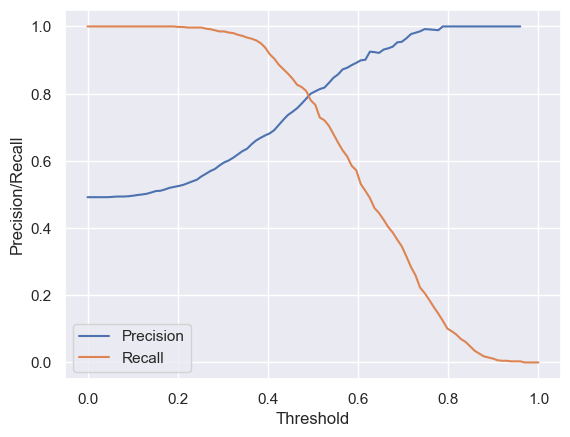

In [36]:
precisions = [precision_threshold(X, Y, t) for t in thresholds]
recalls = [recall_threshold(X, Y, t) for t in thresholds]

plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.legend();

A **precision-recall** curve tests out many possible thresholds. Each point on the curve represents the precision and recall of the classifier for a *particular choice of threshold*.

We choose a threshold value that keeps both precision and recall high (usually in the rightmost "corner" of the curve).

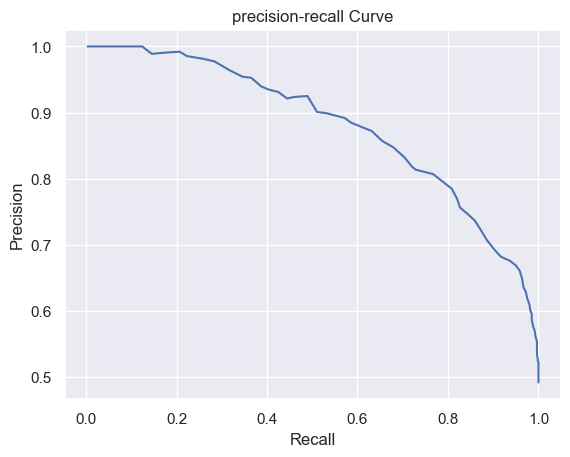

In [37]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("precision-recall Curve");

### ROC Curves

We can repeat a similar experiment for the FPR and TPR. Remember that we want to keep FPR *low* and TPR *high*. 

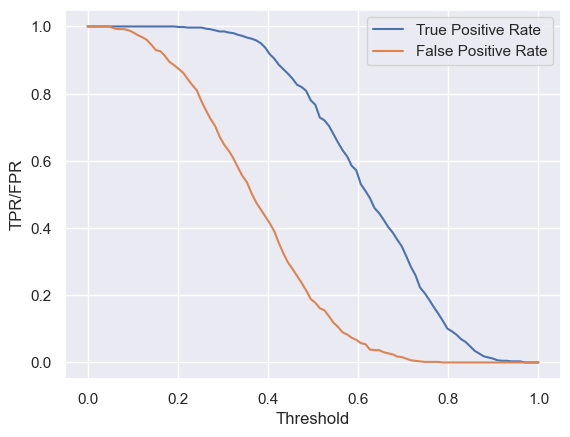

In [38]:
tprs = [tpr_threshold(X, Y, t) for t in thresholds]
fprs = [fpr_threshold(X, Y, t) for t in thresholds]

plt.plot(thresholds, tprs, label="True Positive Rate")
plt.plot(thresholds, fprs, label="False Positive Rate")
plt.xlabel("Threshold")
plt.ylabel("TPR/FPR")
plt.legend();

A **ROC curve** tests many possible decision rule thresholds. For each possible threshold, it plots the corresponding TPR and FPR of the classifier.

"ROC" stands for "Receiver Operating Characteristic". It comes from the field of signal processing.

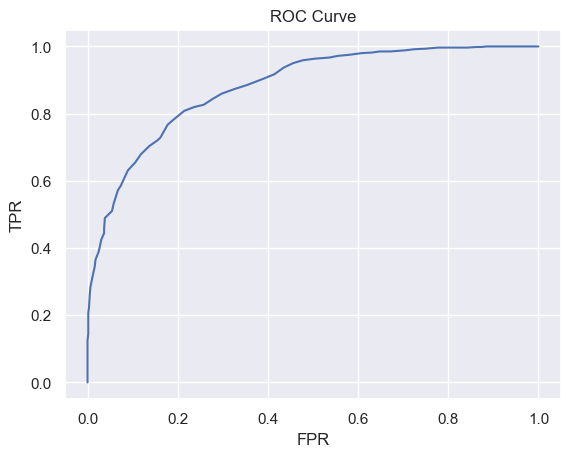

In [39]:
plt.plot(fprs, tprs)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve");

 Ideally, a perfect classifier would have a FPR of 0 and TPR of 1. The area under the perfect classifier is 1. 
 
 We often use the area under the ROC curve (abbreviated "AUC") as an indicator of model performance. The closer the AUC is to 1, the better.

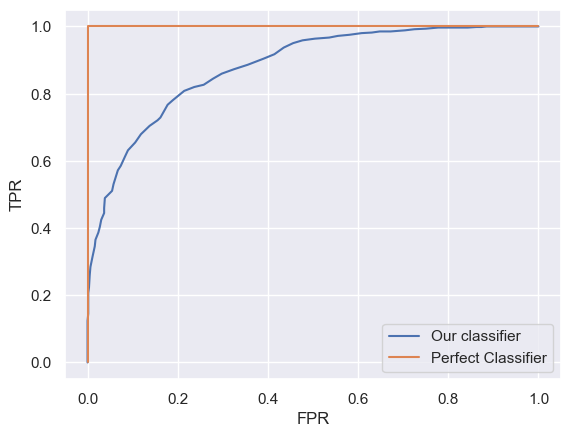

In [40]:
plt.plot(fprs, tprs, label="Our classifier")
plt.plot([0, 0, 1], [0, 1, 1], label="Perfect Classifier")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend();